In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import activations
# from keras.layers import Sequential, MaxPooling2D, Activation, Dense
import numpy as np

In [2]:
class Custom_Layer(keras.layers.Layer):
    def __init__(self, filters):
      super(Custom_Layer, self).__init__()
      self.filters = filters
      
    def build(self, input_shape):      
      self.w = self.add_weight(
        shape=(self.filters, input_shape[-1], input_shape[-1]),
        initializer="random_normal",
        trainable=True,
      )
        # self.b = self.add_weight(
        #     shape=(self.units,), initializer="random_normal", trainable=True
        # )

    def call(self, inputs):      
      
      # num_samples = inputs.shape[0]
      num_samples = tf.shape(inputs)[0]
      # previous_maps = inputs.shape[1]
      previous_maps = tf.shape(inputs)[1]
      # output_maps = tf.zeros((num_samples, self.filters, inputs.shape[2]-2, inputs.shape[3]-2))
      
      output_maps = tf.zeros((num_samples, self.filters, tf.shape(inputs)[2]-2, tf.shape(inputs)[3]-2))

      # axis0 = output_maps.shape[0]
      axis0 = tf.shape(output_maps)[0]
      axis1 = tf.shape(output_maps)[1]
      axis2 = tf.shape(output_maps)[2]
      axis3 = tf.shape(output_maps)[3]
      
      for n in range(axis0):        
        for k in range(axis1):
          x1 = tf.constant(0)
          y1 = tf.constant(3)
          x2 = tf.constant(0)
          y2 = tf.constant(3)
          for i in range(axis2):  
            x1 = tf.constant(0) 
            y1 = tf.constant(3) 
            for j in range(axis3):
              weighted_sum = tf.constant(0.0) 
              for feature in range(previous_maps):
                weighted_sum += tf.math.reduce_sum(tf.matmul(inputs[n, feature, x1:y1, x2:y2], self.w[k, x1:y1, x2:y2]))
              
              sparse_tensor = tf.SparseTensor(indices=[[n, k, i, j]],
                        values=[weighted_sum],
                        dense_shape=[axis0, axis1, axis2, axis3])
              
              output_maps = output_maps + tf.sparse.to_dense(sparse_tensor)
              # output_maps = out_map_results
              x1 += 1
              y1 += 1
            x2 += 1
            y2 += 1
      
      return tf.reshape(output_maps, (axis0, axis1, axis2, axis3))

In [3]:
class Custom_Pooling_Layer(keras.layers.Layer):
    def __init__(self):
      super(Custom_Pooling_Layer, self).__init__()      

    def call(self, inputs):
      pool_output_size = tf.cast(tf.shape(inputs)[2]/2, tf.int32)
      pooled_maps = tf.zeros((tf.shape(inputs)[0], tf.shape(inputs)[1], pool_output_size, pool_output_size))

      end = tf.shape(inputs)[2]
      if end%2 != 0:
        end  = tf.shape(inputs)[2] - 1
      indices = tf.range(0, end, 2)

      axis0 = tf.shape(pooled_maps)[0]
      axis1 = tf.shape(pooled_maps)[1]
      axis2 = tf.shape(pooled_maps)[2]
      axis3 = tf.shape(pooled_maps)[3]

      all_pools = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
      for n in range(axis0):  
        n_pool = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
        for k in range(axis1):
          pool = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
          for index1 in indices:
            for index2 in indices:
              pool = pool.write(pool.size(), tf.reduce_max(inputs[n][k][index1:index1+2, index2:index2+2]))

          n_pool = n_pool.write(n_pool.size(), tf.reshape(pool.stack(), (pool_output_size, pool_output_size)))

        all_pools = all_pools.write(all_pools.size(), tf.stack(n_pool.stack()))

      pooled_maps = tf.stack(all_pools.stack())

      return tf.reshape(pooled_maps, (axis0, axis1, axis2, axis3))

In [ ]:
# x = np.array([tf.ones((1, 6, 6))])
# custom_layer = Custom_Layer(5)
# result = custom_layer(x)


done with custom


In [ ]:
# result

# custom_pooling_layer = Custom_Pooling_Layer()
# pooled_result = custom_pooling_layer(result)

done pooling


In [ ]:
# pooled_result

<tf.Tensor: shape=(1, 5, 2, 2), dtype=float32, numpy=
array([[[[ 0.37178606,  0.76059633],
         [-0.11685783,  0.4274774 ]],

        [[-0.03242315,  0.23989098],
         [-0.09461612,  0.54739714]],

        [[ 0.31843457,  0.5638382 ],
         [ 0.6220293 ,  0.6150039 ]],

        [[ 0.69319135,  0.19828923],
         [ 0.41030735, -0.25768816]],

        [[-0.24946284, -0.05617357],
         [ 0.25766796,  0.07343917]]]], dtype=float32)>

In [16]:
def build_model():
  model = keras.models.Sequential()
  model.add(Custom_Layer(filters=10))
  model.add(layers.Activation(activations.relu))
  model.add(Custom_Pooling_Layer())
  model.add(Custom_Layer(filters=6))
  # model.add(layers.Activation(activations.relu))
  # model.add(Custom_Pooling_Layer())  
  # model.add(Custom_Layer(filters=8))
  # model.add(layers.Activation(activations.relu))
  model.add(layers.Flatten())
  model.add(layers.Dense(units=16, activation="relu"))
  model.add(layers.Dense(units=1, activation="softmax"))

  model.compile(optimizer='sgd', loss='BinaryCrossentropy', metrics=['accuracy'])
  return model    



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd drive/MyDrive/Colab Notebooks/RTAI

/content/drive/MyDrive/Colab Notebooks/RTAI


./dataset/alpaca


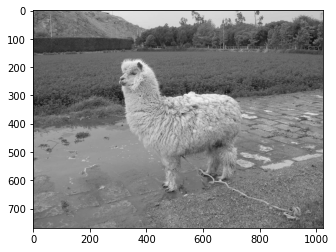

In [7]:
import numpy as np # Used to do several array operations
import matplotlib.pyplot as plt # Used to show the image
import os # Used to iterate through directories and join paths
import cv2 # Used to do some img operations
import tensorflow as tf

Data_Dir = "./dataset"
Categories = ["alpaca", "not alpaca"]

for category in Categories:
  path = os.path.join(Data_Dir, category)  # Path to alpac or not alpaca dir
  print(path)
  for Img in os.listdir(path):  # Iterating through all the images
  # Converting images merely to an array and reading them with 'os.path.join'. Also, converting image to Grayscale.
    Img_array = cv2.imread(os.path.join(path,Img), cv2.IMREAD_GRAYSCALE) 
    plt.imshow(Img_array, cmap = "gray")  # Checking of image
    plt.show() 
    break
  break


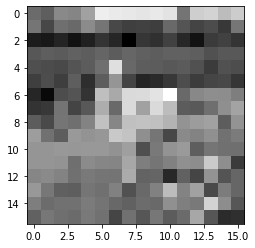

In [8]:
# Resizing of the image
Img_Size = 16 # Every image is 32 x 32

New_Array = cv2.resize(Img_array, (Img_Size,Img_Size))
plt.imshow(New_Array, cmap = 'gray')  # Doing this step to check if Img_Size = 32 works for the dataset or not. If the img is blurry/clear
plt.show()

In [17]:
Training_Data = []

def create_TrainData():
  for category in Categories:
    path = os.path.join(Data_Dir, category)  # Path to alpac or not alpaca dir
    Class_Num = Categories.index(category) # Assigning number to classes using their index, i.e., alpaca = [0] not alpaca = [1]
    # Iterating through all the images
    for Img in os.listdir(path): 
      try:
        Img_array = cv2.imread(os.path.join(path,Img), cv2.IMREAD_GRAYSCALE) # Converting images merely to an array and reading them with 'os.path.join'. Also, converting image to Grayscale.
        New_Array = cv2.resize(Img_array, (Img_Size,Img_Size)) # Performing resizing operation
        # Appending new array and classification to the list
        Training_Data.append([New_Array, Class_Num])
      except Exception as e:
        pass # If an exception is raised for eg if the img is distorted the img wouldn't be considered.

create_TrainData()
     

In [18]:
import random

random.shuffle(Training_Data) #Shuffling of data for better training

In [19]:
X = [] # Features
y = [] # Labels

for features, labels in Training_Data:
  X.append(features)
  y.append(labels)
  
X = np.array(X)
y = np.array(y)
# Since we can't pass a list into a NN especially for features, Converting X into a numpy array
# -1 for how many features we have..it's kind of like a bound. 1 because the image is in grayscale.
X = np.array(X).reshape(-1, 1, Img_Size, Img_Size) 

In [20]:
X = tf.cast(X, tf.float32)

In [21]:
model_nn = build_model()

In [22]:
model_nn.fit(X, y, epochs=5)
# model_nn.fit(X, y)

Epoch 1/5
11/11 [==============================] - 470s 41s/step - loss: nan - accuracy: 0.4832
Epoch 2/5
11/11 [==============================] - 464s 42s/step - loss: nan - accuracy: 0.4343
Epoch 3/5
11/11 [==============================] - 459s 41s/step - loss: nan - accuracy: 0.4343
Epoch 4/5
11/11 [==============================] - 461s 42s/step - loss: nan - accuracy: 0.4343
Epoch 5/5
11/11 [==============================] - 461s 42s/step - loss: nan - accuracy: 0.4343


In [23]:
model_nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom__layer_1 (Custom_Lay  (None, 10, 14, 14)       2560      
 er)                                                             
                                                                 
 activation_1 (Activation)   (None, 10, 14, 14)        0         
                                                                 
 custom__pooling__layer_1 (C  (None, 10, 7, 7)         0         
 ustom_Pooling_Layer)                                            
                                                                 
 custom__layer_2 (Custom_Lay  (None, 6, 5, 5)          294       
 er)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 150)               0         
                                                      